In [1]:
# import libraries
from numpy import array
from numpy import hstack

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate

2022-12-25 11:08:09.169350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-25 11:08:09.169375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Multivariate data preparation

two or more parallel input time series and an output time series that is dependent on the input time series.

In [2]:
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
print(dataset)

[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]]


In [3]:
# define a function named split sequences() that will take a dataset as 
# we have defined it with rows for time steps and columns for parallel series and 
# return input/output samples.

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
    

In [4]:
# choose a number of time steps
n_steps = 3

# transform to a supervised learning problem
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

# separate input data
X1 = X[:, :, 0]
X2 = X[:, :, 1]
print(X1.shape)
print(X2.shape)

# Flatten the shape of the input samples. 
# MLPs require that the shape of the input portion of each sample is a vector.
# Flatten the temporal structure of each input sample

n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

print(X.shape)

(7, 3, 2) (7,)
(7, 3)
(7, 3)


## Functional Model

In [6]:
# first input model
visible1 = Input(shape=(n_steps,))
dense1 = Dense(100, activation= 'relu' )(visible1)

# second input model
visible2 = Input(shape=(n_steps,))
dense2 = Dense(100, activation= 'relu' )(visible2)

# merge input models
merge = concatenate([dense1, dense2])
output = Dense(1)(merge)

model = Model(inputs=[visible1, visible2], outputs=output)
# model.summary()

# configure model
model.compile(optimizer= 'adam' , loss= 'mse' )

2022-12-25 11:08:12.830932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-25 11:08:12.830966: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-25 11:08:12.830986: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (seetha-HP-348-G4): /proc/driver/nvidia/version does not exist
2022-12-25 11:08:12.831276: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


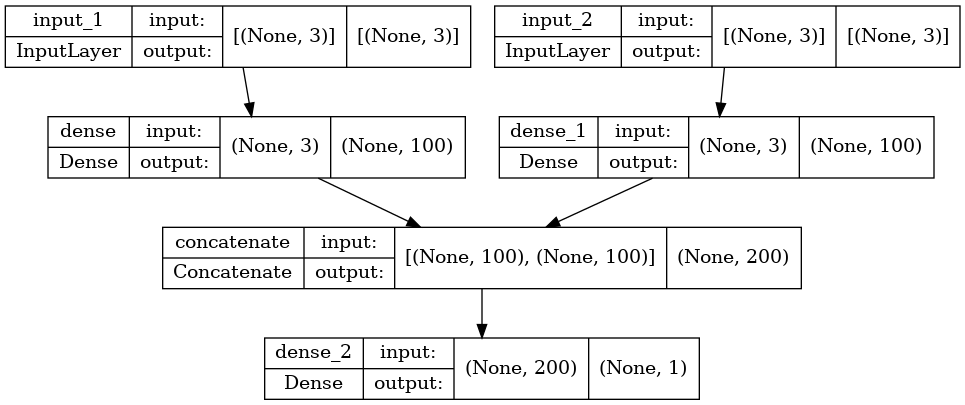

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='4B.png', 
    show_shapes=True,show_dtype=False, show_layer_names=True,)

from IPython.display import Image
Image(filename='4B.png') 

In [8]:
# Training
# fit model
history = model.fit([X1,X2], y, epochs=2000, verbose=0)

In [9]:
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x1 = x_input[:, 0].reshape((1, n_steps))
x2 = x_input[:, 1].reshape((1, n_steps))

yhat = model.predict([x1, x2], verbose=0)
print(yhat)

[[205.19504]]
